<a href="https://colab.research.google.com/github/Codes-of-Hermit/Finance_codes/blob/main/Natural_Gas_Price_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.optimize import curve_fit

In [10]:
# 1. Load and Process Data
from google.colab import files
uploaded = files.upload()
def load_data(filename='Nat_Gas.csv'):
    df = pd.read_csv(filename)
    df['Dates'] = pd.to_datetime(df['Dates'])
    return df


Saving Nat_Gas.csv to Nat_Gas.csv


/tmp/ipython-input-1059867440.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


Model Trained.
Trend: Prices increase by $0.55 per year.
Seasonality: Prices fluctuate by +/- $0.69 due to season.


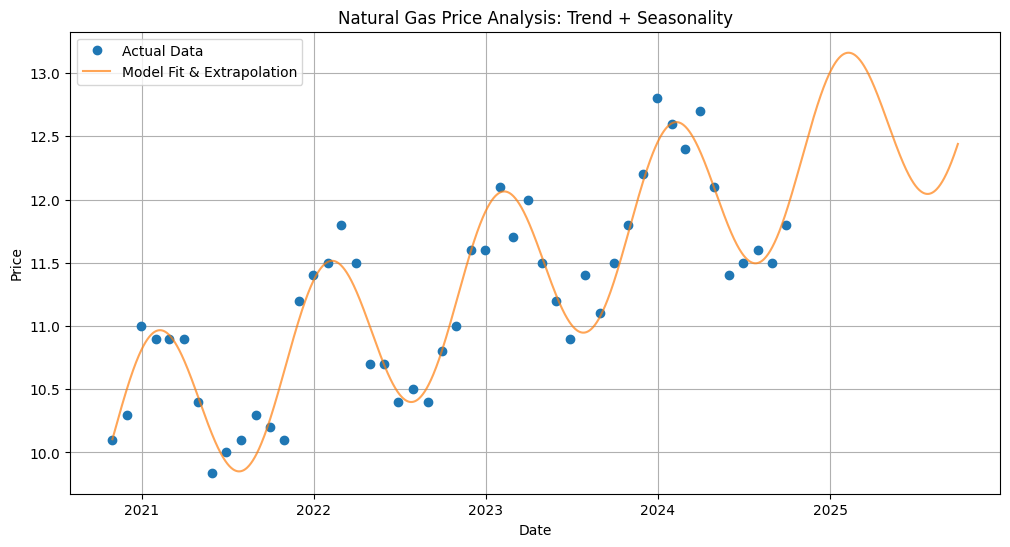

Estimated Price for 2025-06-30: $12.11


In [11]:
# 2. Define the Model Function (Linear Trend + Sine Wave Seasonality)
def price_model(t, slope, intercept, amplitude, shift):
    """
    t: time in days
    Returns estimated price based on linear trend + seasonal sine wave
    """
    # 2*pi / 365.25 ensures the cycle repeats roughly once a year
    frequency = 2 * np.pi / 365.25
    return slope * t + intercept + amplitude * np.sin(frequency * t + shift)

# 3. Fit the Model to the Data
def train_model(df):
    # Convert dates to "Days from Start" for mathematical fitting
    start_date = df['Dates'].min()
    days_data = (df['Dates'] - start_date).dt.days
    price_data = df['Prices']

    # Initial guesses for the optimizer [slope, intercept, amplitude, shift]
    # Slope ~ 0, Intercept ~ mean, Amplitude ~ range/2
    p0 = [0, np.mean(price_data), np.std(price_data), 0]

    # Fit the curve
    params, _ = curve_fit(price_model, days_data, price_data, p0=p0)
    return params, start_date

# 4. Estimation Function
def get_estimated_price(target_date_str, params, start_date_ref):
    """
    Input: target_date_str (e.g., '2025-12-25')
    Output: Estimated price
    """
    target_date = pd.to_datetime(target_date_str)

    # Calculate t (days since the start of our data)
    days_delta = (target_date - start_date_ref).days

    # Predict using the fitted parameters
    return price_model(days_delta, *params)

# --- Execution ---

# Load data
df = load_data()

# Train the model
params, start_ref = train_model(df)
slope, intercept, amplitude, shift = params

print(f"Model Trained.")
print(f"Trend: Prices increase by ${slope*365:.2f} per year.")
print(f"Seasonality: Prices fluctuate by +/- ${abs(amplitude):.2f} due to season.")

# Visualization
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df['Dates'], df['Prices'], 'o', label='Actual Data')

# Plot model curve (Past + 1 Year Future)
total_days = (df['Dates'].max() - df['Dates'].min()).days + 365
days_range = np.arange(0, total_days)
model_dates = [start_ref + timedelta(days=int(d)) for d in days_range]
model_prices = price_model(days_range, *params)

plt.plot(model_dates, model_prices, '-', label='Model Fit & Extrapolation', alpha=0.7)
plt.title('Natural Gas Price Analysis: Trend + Seasonality')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Test Estimation
test_date = "2025-06-30" # Future date
estimate = get_estimated_price(test_date, params, start_ref)
print(f"Estimated Price for {test_date}: ${estimate:.2f}")